# FSW Ephemeris analysis 

APID: 610

In [ ]:
%load_ext autoreload

import pymongoarrow as pma

from pymongoarrow.monkey import patch_all
patch_all()

from pymongo import MongoClient
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np

# Connect to MongoDB
try:
    client = MongoClient()
    client.server_info()  # Test connection
    print("Connected to MongoDB successfully!")
except Exception as e:
    print(f"Failed to connect to MongoDB: {e}")
    exit(1)

database = client['flatsat']
coll = database['tlm']

Connected to MongoDB successfully!


In [2]:
# Define column groups
quaternion_cbi_to_cbf_cols = {
    'EPH_Q_CBI2CBF0': 'Quaternion CBI to CBF W',
    'EPH_Q_CBI2CBF1': 'Quaternion CBI to CBF X',
    'EPH_Q_CBI2CBF2': 'Quaternion CBI to CBF Y',
    'EPH_Q_CBI2CBF3': 'Quaternion CBI to CBF Z',
}

quaternion_vnc_to_body_cols = {
    'EPH_Q_VNC2BDY0': 'Quaternion VNC to Body W',
    'EPH_Q_VNC2BDY1': 'Quaternion VNC to Body X',
    'EPH_Q_VNC2BDY2': 'Quaternion VNC to Body Y',
    'EPH_Q_VNC2BDY3': 'Quaternion VNC to Body Z',
}

mag_field_cbi_cols = {
    'EPH_MAGFLD_CBIX': 'Magnetic Field CBI X',
    'EPH_MAGFLD_CBIY': 'Magnetic Field CBI Y',
    'EPH_MAGFLD_CBIZ': 'Magnetic Field CBI Z',
}

mag_field_cbf_cols = {
    'EPH_MAGFLD_CBFX': 'Magnetic Field CBF X',
    'EPH_MAGFLD_CBFY': 'Magnetic Field CBF Y',
    'EPH_MAGFLD_CBFZ': 'Magnetic Field CBF Z',
}

mag_field_body_cols = {
    'EPH_MAGFLD_BDYX': 'Magnetic Field Body X',
    'EPH_MAGFLD_BDYY': 'Magnetic Field Body Y',
    'EPH_MAGFLD_BDYZ': 'Magnetic Field Body Z',
}

mag_field_unit_body_cols = {
    'EPH_MAGFLD_UBDYX': 'Magnetic Field Unit Body X',
    'EPH_MAGFLD_UBDYY': 'Magnetic Field Unit Body Y',
    'EPH_MAGFLD_UBDYZ': 'Magnetic Field Unit Body Z',
}

pos_cbi_cols = {
    'EPH_POS_CBIX': 'Position CBI X',
    'EPH_POS_CBIY': 'Position CBI Y',
    'EPH_POS_CBIZ': 'Position CBI Z',
}

pos_cbf_cols = {
    'EPH_POS_CBFX': 'Position CBF X',
    'EPH_POS_CBFY': 'Position CBF Y',
    'EPH_POS_CBFZ': 'Position CBF Z',
}

vel_cbi_cols = {
    'EPH_VEL_CBIX': 'Velocity CBI X',
    'EPH_VEL_CBIY': 'Velocity CBI Y',
    'EPH_VEL_CBIZ': 'Velocity CBI Z',
}

vel_cbf_cols = {
    'EPH_VEL_CBFX': 'Velocity CBF X',
    'EPH_VEL_CBFY': 'Velocity CBF Y',
    'EPH_VEL_CBFZ': 'Velocity CBF Z',
}

nadir_centric_unit_body_cols = {
    'EPH_NADIRCENTRIC_UBDYX': 'Nadir Centric Unit Body X',
    'EPH_NADIRCENTRIC_UBDYY': 'Nadir Centric Unit Body Y',
    'EPH_NADIRCENTRIC_UBDYZ': 'Nadir Centric Unit Body Z',
}

nadir_detic_unit_body_cols = {
    'EPH_NADIRDETIC_UBDYX': 'Nadir Detic Unit Body X',
    'EPH_NADIRDETIC_UBDYY': 'Nadir Detic Unit Body Y',
    'EPH_NADIRDETIC_UBDYZ': 'Nadir Detic Unit Body Z',
}

sun_unit_body_cols = {
    'EPH_SUN_UBDYX': 'Sun Unit Body X',
    'EPH_SUN_UBDYY': 'Sun Unit Body Y',
    'EPH_SUN_UBDYZ': 'Sun Unit Body Z',
}

vel_unit_body_cols = {
    'EPH_VEL_UBDYX': 'Velocity Unit Body X',
    'EPH_VEL_UBDYY': 'Velocity Unit Body Y',
    'EPH_VEL_UBDYZ': 'Velocity Unit Body Z',
}

sun_pos_cbi_cols = {
    'EPH_SUNPOS_CBIX': 'Sun Position CBI X',
    'EPH_SUNPOS_CBIY': 'Sun Position CBI Y',
    'EPH_SUNPOS_CBIZ': 'Sun Position CBI Z',
}

sun_vel_cbi_cols = {
    'EPH_SUNVEL_CBIX': 'Sun Velocity CBI X',
    'EPH_SUNVEL_CBIY': 'Sun Velocity CBI Y',
    'EPH_SUNVEL_CBIZ': 'Sun Velocity CBI Z',
}

orbital_elements_cols = {
    'EPH_SEMIMAJORAXIS': 'Semi-Major Axis',
    'EPH_ECCENTRICITY': 'Eccentricity',
    'EPH_INCLINATION': 'Inclination',
    'EPH_RIGHTASCENSION': 'Right Ascension',
    'EPH_ARGPERIAPSIS': 'Argument of Periapsis',
    'EPH_TRUEANOMALY': 'True Anomaly',
}

other_cols = {
    'EPH_EPHEMSOURCE': 'Ephemeris Source',
    'EPH_DATAEPOCH': 'Data Epoch',
    'EPH_TIMESINCEORIGIN': 'Time Since Origin (s)',
    'EPH_VEHICLEROLL': 'Vehicle Roll (rad)',
    'EPH_VEHICLEPITCH': 'Vehicle Pitch (rad)',
    'EPH_VEHICLEYAW': 'Vehicle Yaw (rad)',
    'EPH_SOLARBETAANGLE': 'Solar Beta Angle (rad)',
    'EPH_SUNDISTANCE': 'Sun Distance',
    'EPH_ECLIPSE': 'Eclipse',
    'EPH_LATITUDE': 'Latitude (deg)',
    'EPH_LONGITUDE': 'Longitude (deg)',
    'EPH_ALTITUDE': 'Altitude',
    'EPH_ALTITUDECENTRIC': 'Altitude Centric',
}

# Combine all column groups into a single dictionary
ephemeris_cols = {
    "Quaternion CBI to CBF": quaternion_cbi_to_cbf_cols,
    "Quaternion VNC to Body": quaternion_vnc_to_body_cols,
    "Magnetic Field CBI": mag_field_cbi_cols,
    "Magnetic Field CBF": mag_field_cbf_cols,
    "Magnetic Field Body": mag_field_body_cols,
    "Magnetic Field Unit Body": mag_field_unit_body_cols,
    "Position CBI": pos_cbi_cols,
    "Position CBF": pos_cbf_cols,
    "Velocity CBI": vel_cbi_cols,
    "Velocity CBF": vel_cbf_cols,
    "Nadir Centric Unit Body": nadir_centric_unit_body_cols,
    "Nadir Detic Unit Body": nadir_detic_unit_body_cols,
    "Sun Unit Body": sun_unit_body_cols,
    "Velocity Unit Body": vel_unit_body_cols,
    "Sun Position CBI": sun_pos_cbi_cols,
    "Sun Velocity CBI": sun_vel_cbi_cols,
    "Orbital Elements": orbital_elements_cols,
    #"Other Metrics": other_cols,       # Uncomment to include other metrics
}

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

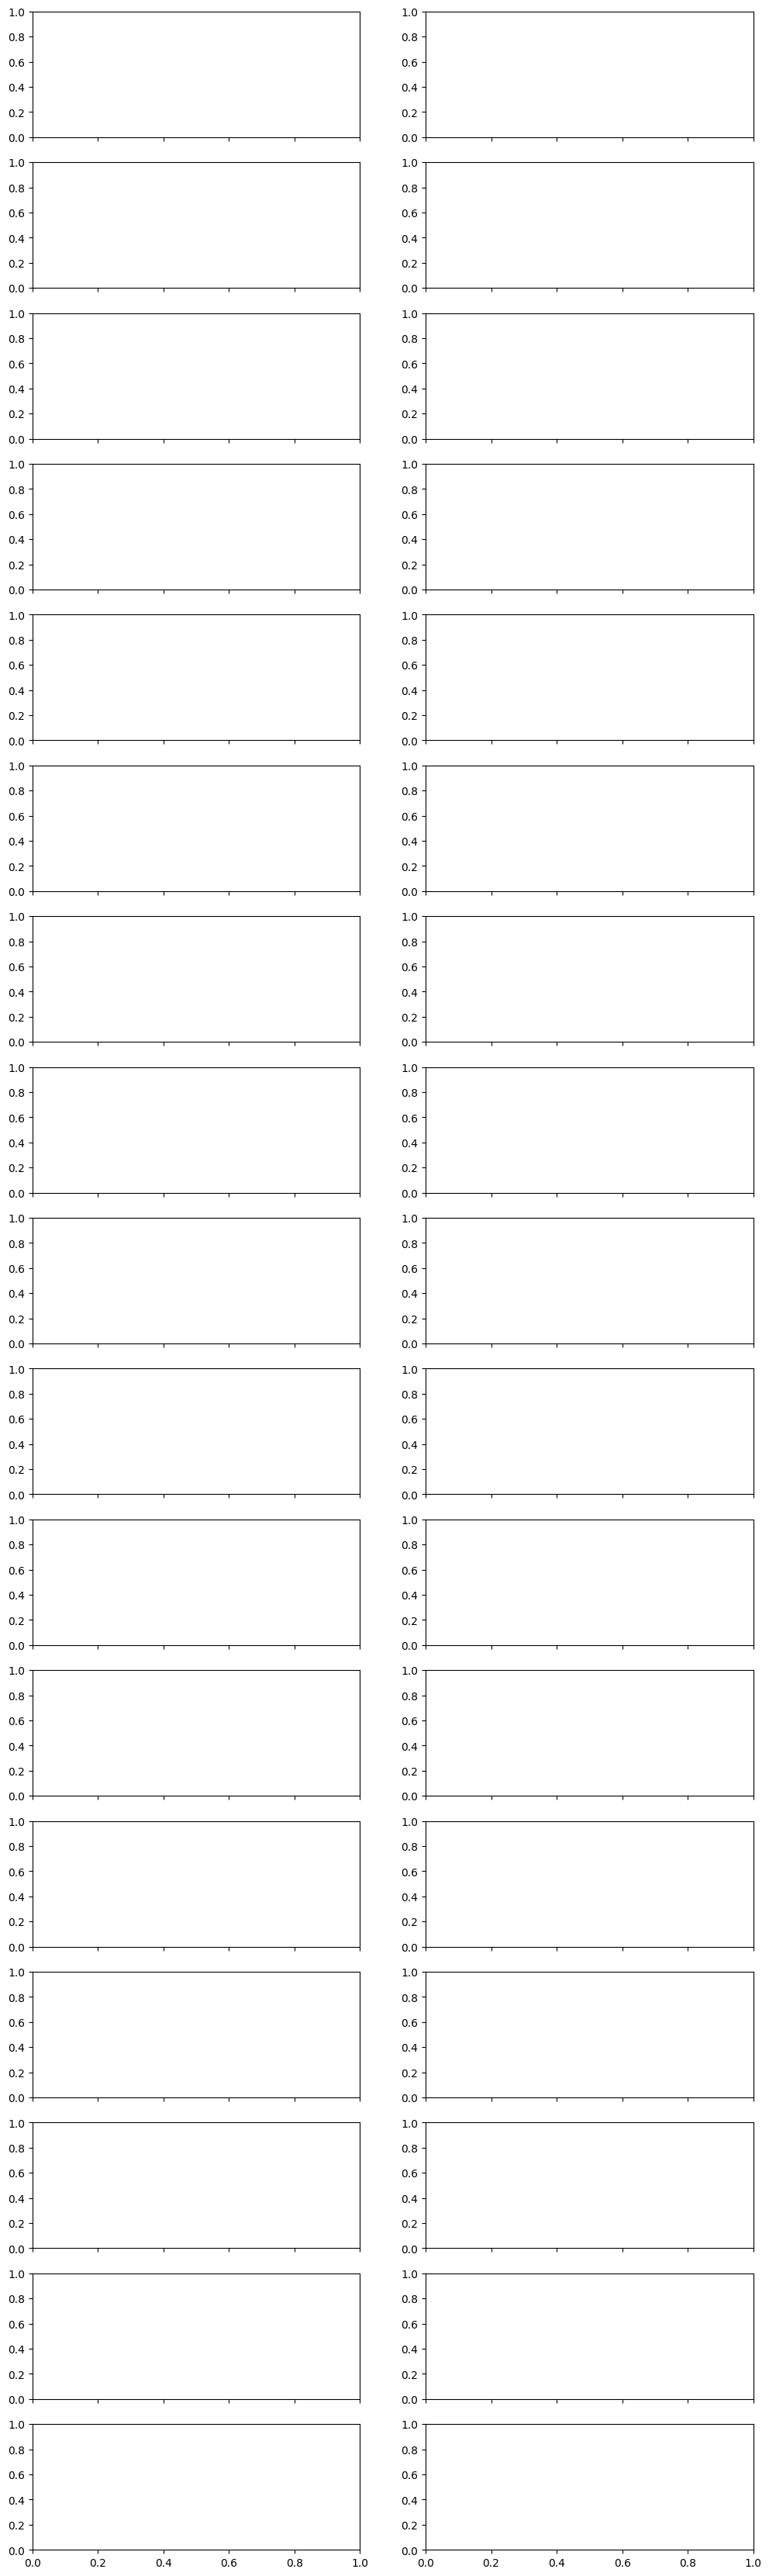

In [4]:
from graph_functions.plot_telemetry import plot_atd_summary

fig, axs = plot_atd_summary(coll, 'EPH_FSW_EPHEMERIS', ephemeris_cols, start_time=pd.Timestamp("2025-09-26 12:00:00"), end_time=pd.Timestamp("2025-09-26 17:00:00"))

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

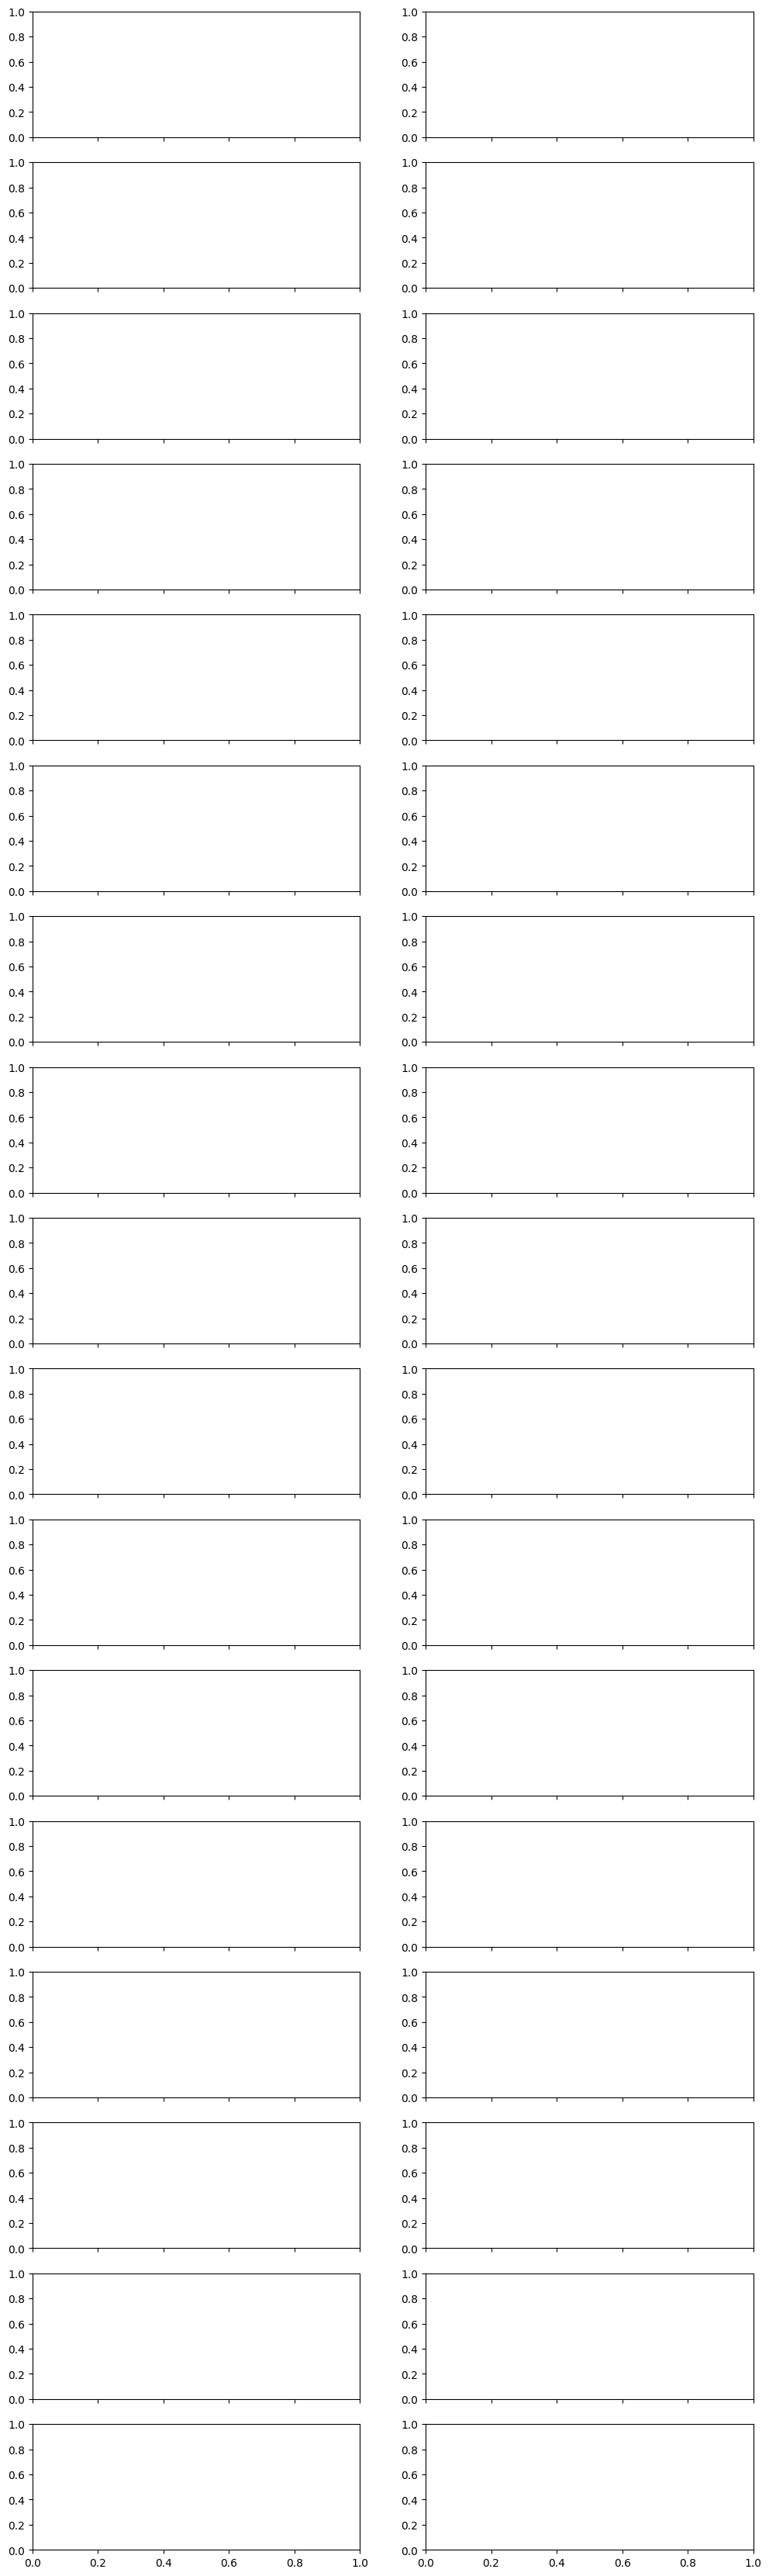

In [3]:
from graph_functions.plot_telemetry import plot_atd_summary

fig, axs = plot_atd_summary(coll, 'EPH_FSW_EPHEMERIS', ephemeris_cols, start_time=pd.Timestamp("2025-09-26 12:00:00"), end_time=pd.Timestamp("2025-09-26 17:00:00"))

plt.show()